# Problem 2

In [8]:
using LinearAlgebra, Distributions, Statistics, Plots
flatten(x) = [x[i] for i in eachindex(x)];

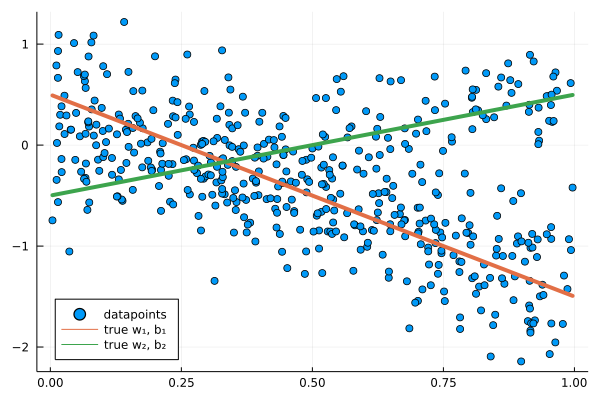

In [9]:
X = rand(500)
p, w, b, σ = [0.7, 0.3], [-2., 1.], [0.5, -0.5], [0.4, 0.3]
function rnormmix(x, p, w, b, σ)
    _p = cumsum(p)
    k = rand()
    for (i, ρ) in enumerate(_p)
        if k < ρ
            return σ[i] * randn() + w[i] * x[1] + b[i]
        end
    end
end
y = [rnormmix(x, p, w, b, σ) for x in eachrow(X)]
fig = scatter(X, y, lab="datapoints", leg=:bottomleft)
fig = plot!(X, x -> w[1]*x + b[1], linewidth=4, lab="true w₁, b₁")
fig = plot!(X, x -> w[2]*x + b[2], linewidth=4, lab="true w₂, b₂")

In [10]:
function ℒ(y, X, p, w, b, σ)
    n, k = length(X), length(b)
    sum( 
        log(sum( p[m] * pdf(Normal(w[m]*X[i] + b[m], σ[m]), y[i])
                 for m in 1:k ))
            for i in 1:n 
    )
end;

In [11]:
function em(X, y, p, w, b, σ)
    n, k = length(X), length(b)
    function _L(i, j)
        _p = [ p[m] * pdf(Normal(w[m] * X[i] + b[m], σ[m]), y[i])
                for m in 1:k ]
        return _p[j] / sum(_p)
    end
    L = [ _L(i, j) for i in 1:n, j in 1:k ]
    p_new = flatten( sum(L, dims=1) ./ sum(L) )

    _X, _L, w_new = hcat(X, ones(n)), [], zeros(k, 2)
    for j in 1:k
        _L = Diagonal(L[:, j])
        w_new[j, :] = (_X' * _L * _X) \ (_X' * _L * y)
    end
    b_new = w_new[:, end]
    w_new = w_new[:, 1]

    σ_new = [sum( L[:, j] .* (w_new[j] .* X .+ b_new[j]).^2 )
             for j in 1:k]
    σ_new = σ_new ./ flatten(sum(L, dims=1))

    return p_new, w_new, b_new, σ_new
end;

In [12]:
p, w, b, σ = [0.5, 0.5], [1., -1.], [0., 0.], [std(y), std(y)]
logℒ = [Inf, ℒ(y, X, p, w, b, σ)]

while abs(logℒ[end] - logℒ[end-1]) > 1e-6
    p, w, b, σ = em(X, y, p, w, b, σ)
    logℒ = push!(logℒ, ℒ(y, X, p, w, b, σ))
end
@show p w b σ;

p = [0.19575849405221357, 0.8042415059477863]
w = [1.0717204086974175, -1.733191161013356]
b = [-0.4652586680109499, 0.4020494977784206]
σ = [0.12528994710643523, 0.42121000304496564]


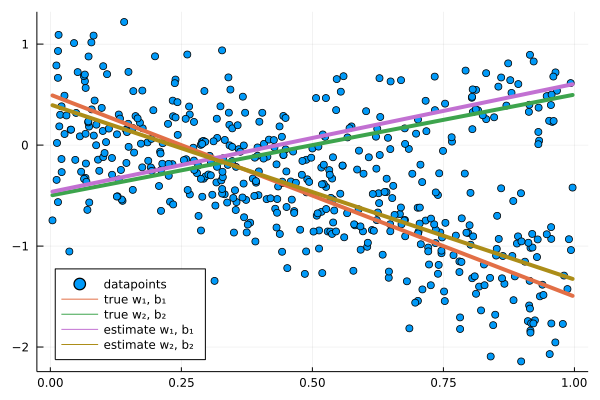

In [13]:
fig = plot!(X, x -> w[1]*x + b[1], linewidth=4, lab="estimate w₁, b₁")
fig = plot!(X, x -> w[2]*x + b[2], linewidth=4, lab="estimate w₂, b₂")

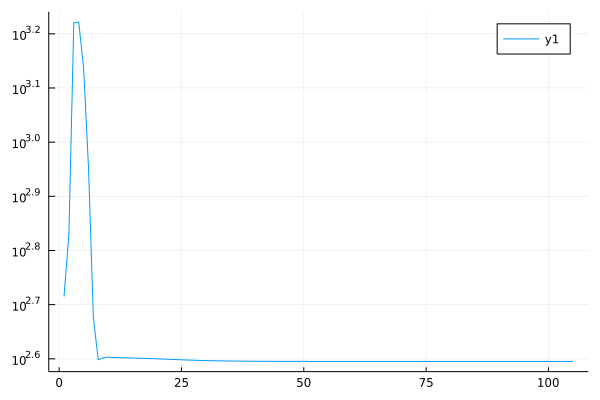

In [14]:
logℒ = .- logℒ[2:end]
fig2 = plot(logℒ, yscale=:log10)